**Dependencies and setup**

This can take a minute or so...

In [1]:
%%capture
!apt update
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 50 # videos can take a very long time to render so only do it every N episodes

**Prepare the environment and wrap it to capture videos**

In [3]:
%%capture
# env = gym.make("BipedalWalker-v3")
env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [4]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


In [5]:
# The code in this project has been copied and adapted from the following repositories:
# https://github.com/honghaow/FORK/blob/master/BipedalWalkerHardcore/TD3_FORK_BipedalWalkerHardcore_Colab.ipynb
# https://github.com/honghaow/FORK/blob/master/TD3-FORK/main_td3_fork.py
# https://github.com/djbyrne/TD3/blob/master/TD3.ipynb
# Individual sections have been referenced where appropriate

In [6]:
# Actor and critic classes from https://github.com/djbyrne/TD3/blob/master/TD3.ipynb
class Actor(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            action output of network with tanh activation
    """
    
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x)) 
        return x


class Critic(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            value output of network 
    """
    
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

In [7]:
# Both classes from https://github.com/honghaow/FORK/blob/master/TD3-FORK/TD3_FORK.py

class Sys_R(nn.Module):
	def __init__(self,state_dim, action_dim, fc1_units, fc2_units):
		super(Sys_R, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(2 * state_dim + action_dim, fc1_units)
		self.l2 = nn.Linear(fc1_units,fc2_units)
		self.l3 = nn.Linear(fc2_units, 1)


	def forward(self, state,next_state, action):
		sa = torch.cat([state,next_state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class SysModel(nn.Module):
	def __init__(self, state_size, action_size, fc1_units, fc2_units):
		super(SysModel, self).__init__()
		self.l1 = nn.Linear(state_size + action_size, fc1_units)
		self.l2 = nn.Linear(fc1_units, fc2_units)
		self.l3 = nn.Linear(fc2_units, state_size)

	def forward(self, state, action):
		"""Build a system model to predict the next state at a given state."""
		xa = torch.cat([state, action], 1)

		x1 = F.relu(self.l1(xa))
		x1 = F.relu(self.l2(x1))
		x1 = self.l3(x1)
		return x1

In [8]:
# Code based on: 
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

# Expects tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=1000000):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        """Add experience tuples to buffer
        
        Args:
            data (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind: 
            s, a, s_, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(s_, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(next_states), np.array(rewards).reshape(-1, 1), np.array(dones).reshape(-1, 1)

In [9]:
# From https://github.com/djbyrne/TD3/blob/master/TD3.ipynb and https://github.com/honghaow/FORK/blob/master/BipedalWalkerHardcore/TD3_FORK_BipedalWalkerHardcore_Colab.ipynb
class TD3(object):
    """Agent class that handles the training of the networks and provides outputs as actions
    
        Args:
            state_dim (int): state size
            action_dim (int): action size
            max_action (float): highest action to take
            device (device): cuda or cpu to process tensors
            env (env): gym environment to use
    
    """
    
    def __init__(self, state_dim, action_dim, max_action, env):
        self.actor = Actor(state_dim, action_dim, max_action).to(device) 
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device) 
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device) 
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)


        sys1_units = 400
        sys2_units = 300
        r1_units = 256
        r2_units = 256
        self.sysmodel = SysModel(state_dim, action_dim, sys1_units,sys2_units).to(device)
        self.sysmodel_optimizer = torch.optim.Adam(self.sysmodel.parameters(), lr=3e-4)
        self.sysmodel.apply(self.init_weights)

        self.sysr = Sys_R(state_dim, action_dim, r1_units, r2_units).to(device)
        self.sysr_optimizer = torch.optim.Adam(self.sysr.parameters(), lr=3e-4)

        self.max_action = max_action
        self.env = env


        self.obs_lower_bound = float(self.env.observation_space.high[0]) #state space upper bound
        self.obs_upper_bound = float(self.env.observation_space.low[0])  #state space lower bound

        sys_threshold = 0.01 # System threshold l

        self.sys_threshold = sys_threshold


    def init_weights(self,m):
      if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.001)
           
    def select_action(self, state, noise=0.1):
        """Select an appropriate action from the agent policy
        
            Args:
                state (array): current state of environment
                noise (float): how much noise to add to acitons
                
            Returns:
                action (float): action clipped within action range
        
        """
        
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0: 
            action = (action + np.random.normal(0, noise, size=self.env.action_space.shape[0]))
            
        return action.clip(self.env.action_space.low, self.env.action_space.high)

    
    def train(self, replay_buffer, iterations, adaptive_weight, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        """Train and update actor and critic networks
        
            Args:
                replay_buffer (ReplayBuffer): buffer for experience replay
                iterations (int): how many times to run training
                batch_size(int): batch size to sample from replay buffer
                discount (float): discount factor
                tau (float): soft update for main networks to target networks
                
            Return:
                actor_loss (float): loss from actor network
                critic_loss (float): loss from critic network
        
        """
        
        for it in range(iterations):

            # Sample replay buffer 
            x, y, u, r, d = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(1 - d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(u).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic MSE loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()



            #Train system and reward model
            predict_next_state = self.sysmodel(state, action)
            predict_next_state = predict_next_state.clamp(self.obs_lower_bound, self.obs_upper_bound)
            sysmodel_loss = F.smooth_l1_loss(predict_next_state, next_state.detach())

            self.sysmodel_optimizer.zero_grad()
            sysmodel_loss.backward()
            self.sysmodel_optimizer.step()
            self.sysmodel_loss = sysmodel_loss.item()


            predict_reward = self.sysr(state,next_state,action)
            sysr_loss = F.mse_loss(predict_reward, reward.detach())
            self.sysr_optimizer.zero_grad()
            sysr_loss.backward()
            self.sysr_optimizer.step()
            self.sysr_loss = sysr_loss.item()

            s_flag = 1 if sysmodel_loss.item() < self.sys_threshold else 0


            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss1 = -self.critic.Q1(state, self.actor(state)).mean()


                if s_flag == 1:
                  p_next_state = self.sysmodel(state, self.actor(state))
                  p_next_state = p_next_state.clamp(self.obs_lower_bound,self.obs_upper_bound)
                  actions2 = self.actor(p_next_state.detach())
                  
                  # TD3-FORK used
                  p_next_r = self.sysr(state,p_next_state.detach(),self.actor(state))
                  p_next_state2 = self.sysmodel(p_next_state, self.actor(p_next_state.detach()))
                  p_next_state2 = p_next_state2.clamp(self.obs_lower_bound,self.obs_upper_bound)
                  p_next_r2 = self.sysr(p_next_state.detach(),p_next_state2.detach(),self.actor(p_next_state.detach()))
                  actions3 = self.actor(p_next_state2.detach())
                  actor_loss2 =  self.critic.Q1(p_next_state2.detach(),actions3)
                  actor_loss3 = -(p_next_r + self.discount * p_next_r2 + self.discount ** 2 * actor_loss2).mean()


                  actor_loss = (actor_loss1 + adaptive_weight * actor_loss3)


                  lmbda = 2.5/actor_loss1.abs().detach()

                  actor_loss = -lmbda * actor_loss + F.mse_loss(self.actor(state), action)

      
                  self.update_sys += 1
                else:
                  actor_loss = actor_loss1

                # Optimize the actor
                self.critic_optimizer.zero_grad()
                self.sysmodel_optimizer.zero_grad()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))


    def load(self, filename="best_avg", directory="./saves"):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

In [10]:
max_action = float(env.action_space.high[0])

# initialise agent
agent = TD3(obs_dim, act_dim, max_action, env)
done = False
# initialise replay buffer
replay_buffer = ReplayBuffer()

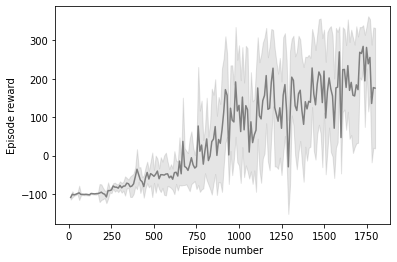

In [11]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")

max_episodes = 1800 # use 800 for basic
max_timesteps = 2000
start_timesteps = 10000 # as stated in paper

timestep_count = 0
expcount = 0

state = env.reset()

# The following has been copied and adapted from https://github.com/honghaow/FORK/blob/master/BipedalWalkerHardcore/TD3_FORK_BipedalWalkerHardcore_Colab.ipynb

# training procedure:
for episode in range(1, max_episodes+1):
    ep_reward_list = []
    temp_replay_buffer = []
    # state = env.reset()
    for t in range(max_timesteps):
        timestep_count += 1

        if timestep_count <= start_timesteps:
            # sample random action in observation stage
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)
          
        next_state, reward, done, _ = env.step(action)

        ep_reward += reward

        if reward == -100:
              add_reward = -1
              reward = -5
              expcount += 1

        else:
              add_reward = 0
              reward *= 5
        temp_replay_buffer.append((state, next_state, action, reward, done))

        state = next_state
        
        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):

            # My implementation of 5:1 ratio
            if add_reward == -1 or ep_reward < 250:        
                for temp in temp_replay_buffer:
                    for i in range(5):
                      replay_buffer.add(temp)
            else:
                for temp in temp_replay_buffer:
                    replay_buffer.add(temp)

            # append the episode reward to the reward list
            reward_list.append(ep_reward)

            # reward list per episode (used for adaptive weight)
            ep_reward_list.append(ep_reward)
            if timestep_count > start_timesteps:

              r_0 = 320 # Base Cumulative Reward r0
              w_0 = 0.6 # Base Weight w0
              adaptive_weight = np.round((1 - np.clip(np.mean(ep_reward_list[-100:])/r_0, 0, 1)),4) * w_0

              agent.train(replay_buffer, t, adaptive_weight)

            state = env.reset()
            done = False
            break



    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0
    
    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)
 


In [12]:
agent.save("./saves", "./")